# Every person's face

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from IPython.display import HTML
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01b import *

### Data

In [ ]:
SOURCE = Path('../data/train_sample_videos/')

In [ ]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


### Some frames have one person's face, some have two people's faces

In [ ]:
fn = SOURCE/annots.fname[20]
HTML(html_vid(fn))

In [ ]:
mtcnn_params = dict(device='cuda:0' if torch.cuda.is_available() else 'cpu',
                    image_size=256,
                    select_largest=False, post_process=False)
detector = MTCNN(keep_all=True, **mtcnn_params)

In [ ]:
#class VideoCapture(cv2.VideoCapture):
#    def __init__(self, fn):
#        assert Path(fn).exists()
#        super().__init__(str(fn))
#    def __enter__(self, *args): return self
#    def __exit__(self, *args): self.release()
#    def __len__(self): return int(self.get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
#def get_face_unique(vcap:VideoCapture, detector:MTCNN, iframe:int=100):
#    for i in range(len(vcap)):
#        _ = vcap.grab()
#        if i == iframe:
#            success, frame = vcap.retrieve()
#            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#            pilimg = PIL.Image.fromarray(frame)
#            dfaces = detector(pilimg, return_prob=True)
#    return dfaces

In [ ]:
#with VideoCapture(fn) as vcap: dfaces = get_face_unique(vcap, detector)

In [ ]:
def get_face_unique(fn, detector:MTCNN, iframe:int=100):
    assert Path(fn).exists()
    vcap = cv2.VideoCapture(str(fn))
    vlen = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in range(vlen):
        _ = vcap.grab()
        if i == iframe:
            success, frame = vcap.retrieve()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pilimg = PIL.Image.fromarray(frame)
            dfaces = detector(pilimg, return_prob=True)
    vcap.release()
    return dfaces

In [ ]:
dfaces = get_face_unique(fn, detector, 260)

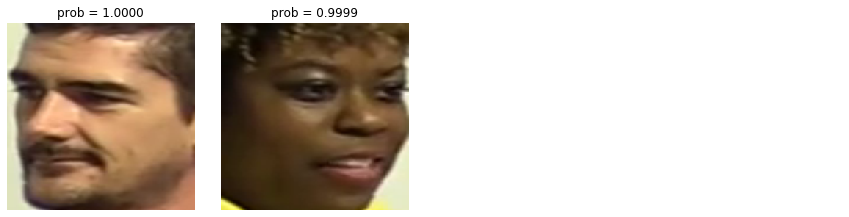

In [ ]:
ncols = 4
nrows = int((len(dfaces[0]) - 1) / ncols) + 1
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axs = axs.flatten()
for ax, p, img in itertools.zip_longest(axs, dfaces[1], dfaces[0]):
    if p: Image(img.type(torch.uint8)).show(ax=ax, title=f'prob = {p:.4f}')
    ax.axis('off')
plt.tight_layout()

### Two people, one wearing a T-shirt with picture of a face

In [ ]:
fn = SOURCE/annots.fname[345]
fn

PosixPath('../data/train_sample_videos/edyncaijwx.mp4')

In [ ]:
HTML(html_vid(fn))

In [ ]:
#with VideoCapture(fn) as vcap: dfaces = get_face_unique(vcap, detector, 90)
dfaces = get_face_unique(fn, detector, 210)

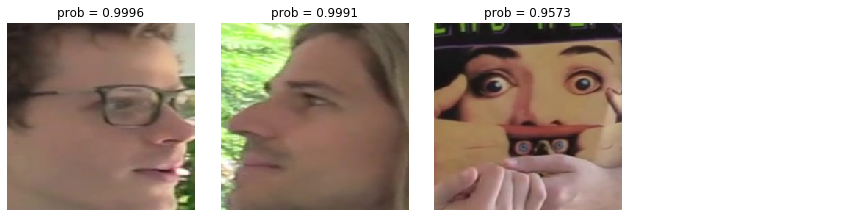

In [ ]:
ncols = 4
nrows = int((len(dfaces[0]) - 1) / ncols) + 1
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axs = axs.flatten()
for ax, p, img in itertools.zip_longest(axs, dfaces[1], dfaces[0]):
    if p: Image(img.type(torch.uint8)).show(ax=ax, title=f'prob = {p:.4f}')
    ax.axis('off')
plt.tight_layout()

In [ ]:
del vcap

In [ ]:
vcap.read()

# - fin